# Model Explainability: XGBoost Fraud Detection

## Objective
Interpret the predictions of the final XGBoost model used for fraud detection.

This notebook provides:
- **Global feature importance** using gain
- **Global model behavior** using SHAP summary plots
- **Local explanations** for individual fraud predictions using SHAP waterfall plots

All explanations are generated using the **exact trained XGBoost model** from Part C.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from pathlib import Path
import joblib

import shap
import xgboost as xgb_lib


In [5]:
# Load processed data + feature names
X_train = np.load("../data/processed/v1_train_test/X_train_scaled.npy")
X_test  = np.load("../data/processed/v1_train_test/X_test_scaled.npy")
y_train = np.load("../data/processed/v1_train_test/y_train.npy")
y_test  = np.load("../data/processed/v1_train_test/y_test.npy")

with open(Path("../data/processed/v1_train_test/feature_names.json"), "r") as f:
    feature_names = json.load(f)

# Load trained model from Part C (no retraining)
xgb = joblib.load("../models/xgb_model.joblib")
booster = xgb.get_booster()

# Probabilities for later local explanation
xgb_proba = xgb.predict_proba(X_test)[:, 1]


## Global Feature Importance (Gain)

This plot shows feature importance measured by **gain**, which represents the
average reduction in loss when a feature is used in a split.

Key observations:
- A small subset of latent components dominates model decisions
- Features such as **V14, V10, V12, and V4** contribute most to fraud detection
- The distribution is not uniform, indicating the model has learned meaningful patterns


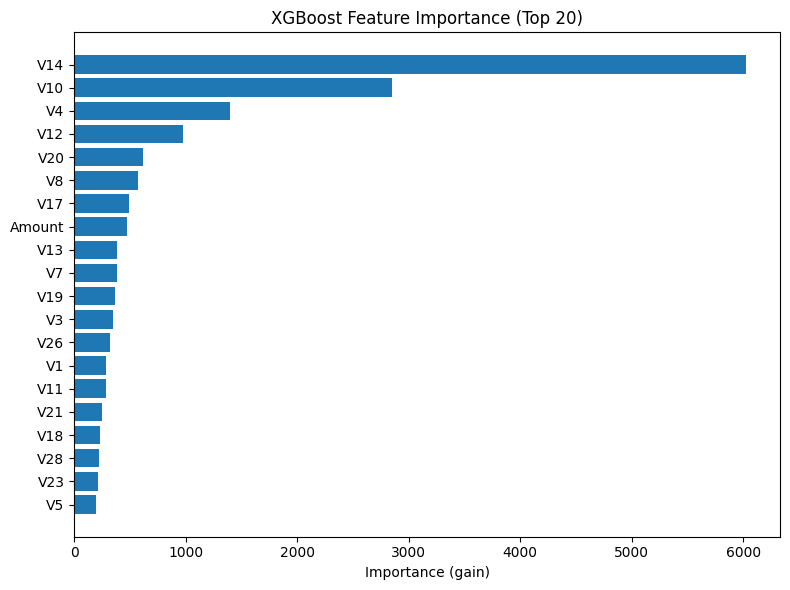

In [7]:
score = booster.get_score(importance_type="gain")
importances = np.array([score.get(f"f{i}", 0.0) for i in range(len(feature_names))])

top_k = 20
idx = np.argsort(importances)[-top_k:]
top_features = [feature_names[i] for i in idx]
top_values = importances[idx]

plt.figure(figsize=(8, 6))
plt.barh(top_features, top_values)
plt.xlabel("Importance (gain)")
plt.title(f"XGBoost Feature Importance (Top {top_k})")
plt.tight_layout()
plt.show()


## SHAP Global Summary

The SHAP summary plot explains how features influence predictions **across all samples**.

Interpretation:
- Feature rankings are consistent with gain-based importance
- High-magnitude SHAP values indicate strong influence on predictions
- Color gradients show how feature values push predictions toward fraud or non-fraud
- Non-linear and asymmetric effects confirm why XGBoost outperforms linear models


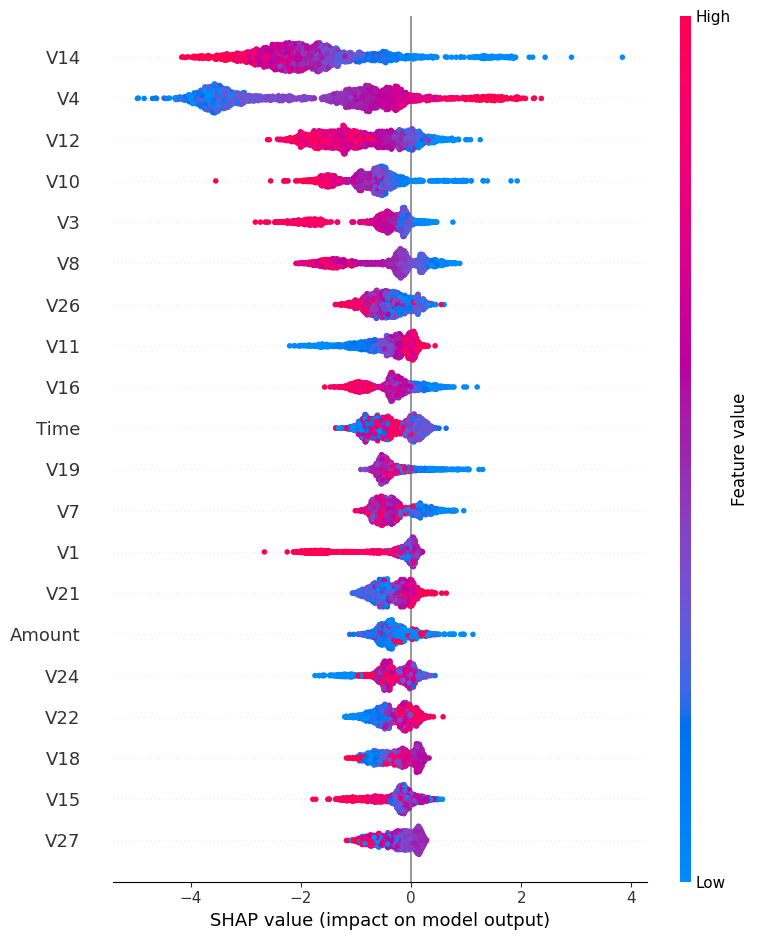

In [9]:
X_shap = pd.DataFrame(X_test[:2000], columns=feature_names)

dmat = xgb_lib.DMatrix(X_shap, feature_names=feature_names)
contrib = booster.predict(dmat, pred_contribs=True)

shap_values = contrib[:, :-1]
base_values = contrib[:, -1]

shap.summary_plot(shap_values, X_shap, feature_names=feature_names)
